All instructions are provided for R. I am going to reproduce them in Python as best as I can.

# Preface

From the textbook, p. 126:
> This problem involves the `Boston` data set, which we saw in the lab
for this chapter. We will now try to predict per capita crime rate
using the other variables in this data set. In other words, per capita
crime rate is the response, and the other variables are the predictors.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_boston
import statsmodels.api as sm


sns.set()
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
boston = load_boston()
# Because this exercise requires all features to be in one table,
# loading straight from the CSV is easier.
bostondf = pd.read_csv(boston.filename, skiprows=1)

predictors = (bostondf.drop('CRIM', axis='columns')
                      .assign(intercept=1)
)
target = bostondf.CRIM

# (a)

From the textbook, p. 126:
> For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions.

In [3]:
rows = []
preds = predictors.columns.to_list()
preds.remove('intercept')
for pred in preds:
  model = sm.regression.linear_model.OLS(target, predictors[['intercept', pred]]).fit(use_t=True)
  rows.append([pred
               , model.rsquared
               , model.params[pred]
               , model.pvalues[pred]
              ]
             )
single_pred_params = pd.DataFrame(rows, columns=['predictor', 'R2', 'slope', 'p-value']) \
                                   .set_index('predictor')
single_pred_params

,R2,slope,p-value
predictor,,,
ZN,0.040188,-0.073935,5.506472e-06
INDUS,0.165310,0.509776,1.450349e-21
CHAS,0.003124,-1.892777,2.094345e-01
NOX,0.177217,31.248531,3.751739e-23
RM,0.048069,-2.684051,6.346703e-07
AGE,0.124421,0.107786,2.854869e-16
DIS,0.144149,-1.550902,8.519949e-19
RAD,0.391257,0.617911,2.693844e-56
TAX,0.339614,0.029742,2.357127e-47


In single-predictor models, all the predictors, except `CHAS` have a statistically significant association with `CRIM`.

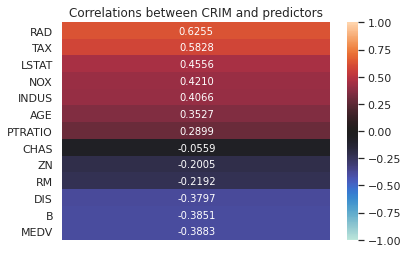

In [4]:
single_pred_corrs = (predictors.drop('intercept', axis='columns')
                               .corrwith(target)
                               .sort_values(ascending=False)
                               .to_frame('')
)
sns.heatmap(single_pred_corrs
            , vmin=-1
            , vmax=1
            , cmap='icefire'
            , annot=True
            , fmt='.4f'
)
plt.title('Correlations between CRIM and predictors')
plt.show()

Since `CHAS` has almost no association with `CRIM`, and 12 predictors look better on a grid than 13, I'm not plotting `CHAS` - `CRIM` scatterplot.

In [5]:
preds = single_pred_corrs.index.to_list()

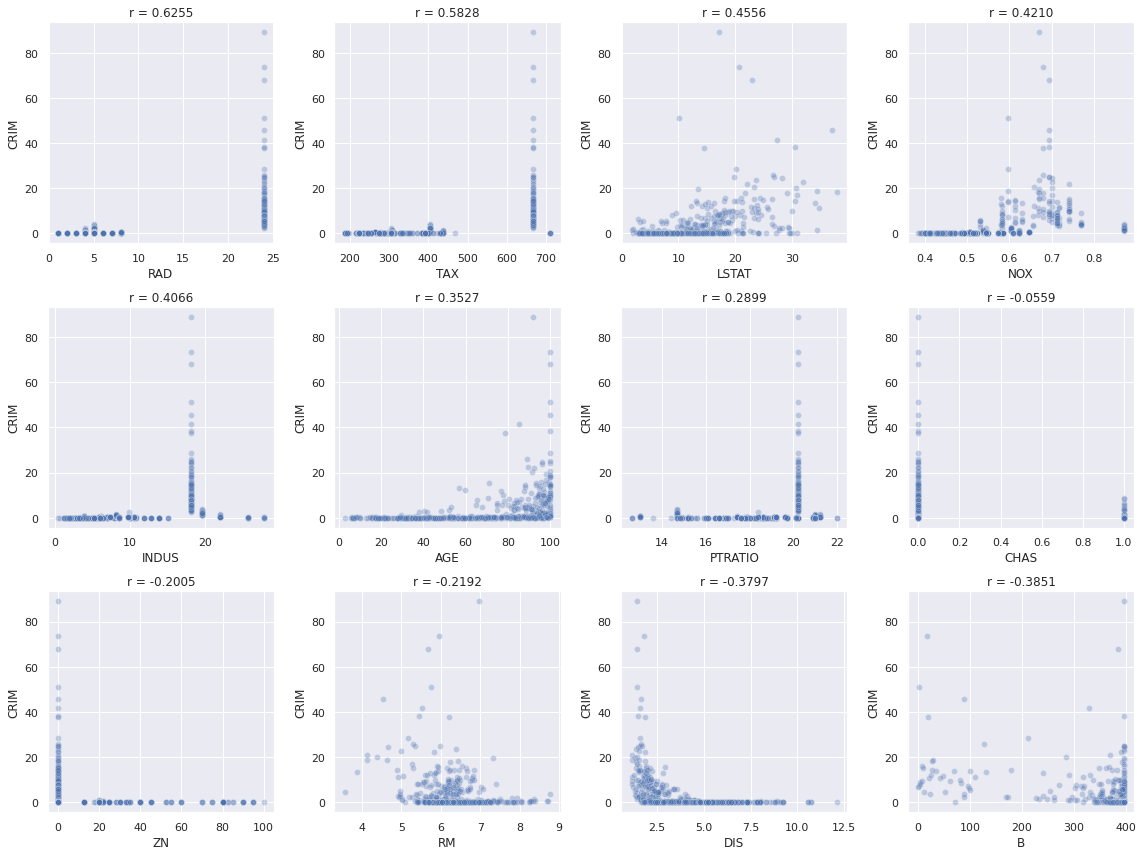

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
axs = axs.flatten()

for ax, pred in zip(axs, preds):
  sns.scatterplot(x=pred, y=target, data=predictors, alpha=0.3, ax=ax)
  ax.set_title(f'r = {float(single_pred_corrs.loc[pred]):.4f}')
plt.tight_layout()

I am not sure how this is helping to prove my assertions.

# (b)

From the textbook, p. 126:
> Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis $H_0: \beta_j = 0$?

In [7]:
model_b = sm.regression.linear_model.OLS(target, predictors).fit(use_t=True)
print(f'R-squared: {model_b.rsquared}\n')
print('p-values:')
model_b.pvalues

R-squared: 0.45401038980421493

p-values:


ZN           1.702489e-02
INDUS        4.442940e-01
CHAS         5.258670e-01
NOX          5.115200e-02
RM           4.830888e-01
AGE          9.354878e-01
DIS          5.022039e-04
RAD          6.460451e-11
TAX          4.637927e-01
PTRATIO      1.466113e-01
B            4.070233e-02
LSTAT        9.620842e-02
MEDV         1.086810e-03
intercept    1.894909e-02
dtype: float64

Although $R^2 = 0.45$ is not that great, the model fits better than any of the single-predictor ones.

At alpha-level of 5%, we can reject the null hypothesis $H_0: \beta_j = 0$ for `DIS`, `B`, `MEDV`, `intercept`.

# (c)

From the textbook, p. 126:
> How do your results from (a) compare to your results from (b)? Create a plot displaying the univariate regression coefficients from (a) on the x-axis, and the multiple regression coefficients from (b) on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

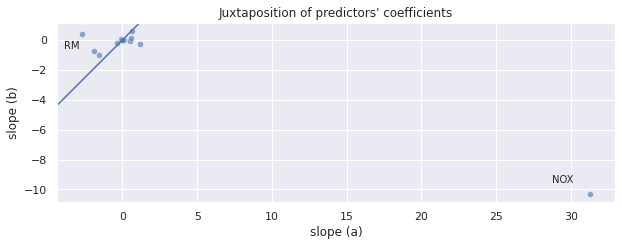

In [8]:
plt.figure(figsize=(10, 10))
coef_juxtaposed = pd.DataFrame({'slope (a)' : single_pred_params['slope']
                                , 'slope (b)' : model_b.params.drop('intercept')
                               }
                              )
ax = sns.scatterplot(
  x='slope (a)'
  , y='slope (b)'
  , data = coef_juxtaposed
  , alpha=0.6
)
plt.annotate('NOX', xy=[31.248531-2.5, -10.029523+0.5])
plt.annotate('RM', xy=[-2.684051-1.2, 0.435912-1])
sm.graphics.abline_plot(0, 1, ax=ax)
ax.set_aspect('equal')
plt.title('Juxtaposition of predictors\' coefficients')
plt.show()

`NOX` and `RM` deviate from the diagonal line (`slope (a)` = `slope (b)`) the most.

# (d)

From the textbook, p. 126:
> Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor $X$, fit a model of the form $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3$.

In [9]:
preds = predictors.columns.to_list()
preds.remove('intercept')
rows = []
for pred in preds:
  predictors_x2_x3 = \
    predictors[['intercept', pred]].assign(**{f'{pred}2' : predictors[pred]**2
                                              , f'{pred}3' : predictors[pred]**3
                                             }
                                          )
  model = sm.regression.linear_model.OLS(target, predictors_x2_x3).fit(use_t=True)

  if model.pvalues[f'{pred}3'] < 0.05:
    degree = 3
  elif model.pvalues[f'{pred}2'] < 0.05:
    degree = 2
  elif model.pvalues[pred] < 0.05:
    degree = 1
  else:
    degree = 0
    
  rows.append([pred
               , model.rsquared
               , model.params[pred]
               , model.pvalues[pred]
               , model.pvalues[f'{pred}2']
               , model.pvalues[f'{pred}3']
               , degree
              ]
             )
  
single_pred_params = (
  pd.DataFrame(rows
               , columns=['predictor'
                          , 'R2'
                          , 'slope'
                          , 'p-value1'
                          , 'p-value2'
                          , 'p-value3'
                          , 'assoc. degree'
                         ]
              ).set_index('predictor')
)
single_pred_params

,R2,slope,p-value1,p-value2,p-value3,assoc. degree
predictor,,,,,,
ZN,0.058242,-0.332188,2.612296e-03,9.375050e-02,2.295386e-01,1
INDUS,0.259658,-1.965213,5.297064e-05,3.420187e-10,1.196405e-12,3
CHAS,0.003124,-0.630926,2.094345e-01,2.094345e-01,2.094345e-01,0
NOX,0.296978,-1279.371252,2.758372e-13,6.811300e-15,6.961110e-16,3
RM,0.067786,-39.150136,2.117564e-01,3.641094e-01,5.085751e-01,0
AGE,0.174231,0.273653,1.426608e-01,4.737733e-02,6.679915e-03,3
DIS,0.277825,-15.554353,6.374792e-18,4.941214e-12,1.088832e-08,3
RAD,0.400037,0.512736,6.234175e-01,6.130099e-01,4.823138e-01,0
TAX,0.368882,-0.153310,1.097075e-01,1.374682e-01,2.438507e-01,0


A lot of predictors have third-degree-polynomial relationship with `CRIM`:
* `INDUS`;
* `NOX`;
* `AGE`;
* `DIS`;
* `PTRATIO`;
* `MEDV`.